## Projeto de Bloco: Engenharia de Dados: Big Data
### TP5
    
- Ingestão
    - Selecionar os 30 livros no formato Plain Text UTF-8
    - Adicionar os arquivos no HDFS
- Limpeza e Normalização
    - Importação dos dados em DataFrames Spark
    - Remoção de caracteres descartáveis
    - Remoção de linha descartáveis
    - Remoção de stop-words
    - Aplicação de lematização
    - Utilização de técnicas complementares, caso julgue necessário
    - DataFrame unificado de informações dos 30 livros selecionados, com as seguintes colunas:
        - Nome do Livro
        - Idioma do Livro
        - Número do Parágrafo (começando com o índice #1)
        - Parágrafo Original (antes da limpeza e normalização)
        - Conjunto de Palavras do Parágrafo (após limpeza e normalização)
        - Outras colunas, caso julgue necessário
- Análise e Mensuração dos tempos
- Responder às seguintes perguntas:
    - Quantidade de palavras únicas utilizadas por livro
    - Quantidade de parágrafos e palavras não-únicas por parágrafo por livro
    - Identificar a palavra que mais aparece e a palavra que menos aparece por parágrafo por livro
    - Dos livros em inglês, selecionar as top-10 palavras que mais aparecem. Fazer o mesmo para os livros em português
    - Montar dois gráficos9,10 de linhas, um para os livros em inglês e o outro para os em português, com o eixo X sendo o índice dos parágrafos, o eixo Y sendo a quantidade de palavras únicas e a linha o livro em questão
    - Montar dois histogramas8,9,10, um para os livros em inglês e o outro para os em português, para análise da frequência de palavras dos livros
- Exibir o tempo gasto no processamento de cada uma das respostas acima


In [1]:
import findspark
import os
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, row_number, max, regexp_replace, trim, split, array_contains, lower, lit, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, ArrayType
from pyspark.sql.window import Window
from pyspark.ml.feature import StopWordsRemover
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conf = SparkConf().setAppName("luis-barbosa-pb-tp5")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
%%time
! hadoop fs -put ../datasets/books

put: `books/14200-0.txt': File exists
put: `books/15047-0.txt': File exists
put: `books/3713-0.txt': File exists
put: `books/3957-0.txt': File exists
put: `books/44226-0.txt': File exists
put: `books/52057-0.txt': File exists
put: `books/56198-0.txt': File exists
put: `books/63606-0.txt': File exists
put: `books/pg21563.txt': File exists
put: `books/pg24625.txt': File exists
put: `books/pg26777.txt': File exists
put: `books/pg27535.txt': File exists
put: `books/pg27689.txt': File exists
put: `books/pg29040.txt': File exists
put: `books/pg29243.txt': File exists
put: `books/pg33274.txt': File exists
put: `books/pg33516.txt': File exists
put: `books/pg35004.txt': File exists
put: `books/pg38496.txt': File exists
put: `books/pg42972.txt': File exists
put: `books/pg44540.txt': File exists
put: `books/pg51076.txt': File exists
put: `books/pg52782.txt': File exists
put: `books/pg59332.txt': File exists
put: `books/pg66447.txt': File exists
put: `books/pg67724.txt': File exists
put: `books/pg

In [4]:
! hadoop fs -ls hdfs://node-master:9000/user/root

Found 2 items
drwxr-xr-x   - root supergroup          0 2023-06-25 21:33 hdfs://node-master:9000/user/root/.sparkStaging
drwxr-xr-x   - root supergroup          0 2023-06-25 16:18 hdfs://node-master:9000/user/root/books


### Auxiliary Functions

In [5]:
def shape(df):
    return (df.count(), len(df.columns))

### Reading txt file

In [6]:
dataset_path = "hdfs://node-master:9000/user/root/books/*"

In [7]:
# método para capturar o valor do "Title" e "Language"
def captureValue(df, field, text, collumn): 
    return df.filter(col(field).contains(text)
        ).select(trim(split(col(field), ":").getItem(1)).alias(collumn)
        ).withColumn(
            collumn, regexp_replace(col(collumn), "[\r\n]", " ")
        ).withColumn(
            collumn, regexp_replace(col(collumn), "\s+", " ")
        ).first()[0]

In [8]:
files_rdd = spark.sparkContext.wholeTextFiles(dataset_path)
dfs = []
WINDOWS_SEP = "\r\n\r\n"

# Percorre cada arquivo .txt separadamente
for file_path, file_content in files_rdd.collect():
    # Aplica o separador e cria a coluna original_paragraph
    dfft_ = spark.read.text(
        [file_path],
        lineSep=WINDOWS_SEP
    ).withColumnRenamed("value", "original_paragraph")
                
    # Utiliza o método para capturar o idioma e o título do livro
    language = captureValue(dfft_, "original_paragraph", "Language:", "language")
    title = captureValue(dfft_, "original_paragraph", "Title:", "title")  
    
    # Aplica o idioma e o título para todas os parágrafos do arquivo que está iterando
    dfft_ = dfft_.withColumn("language", lit(language)
                ).withColumn("title", lit(title)
                ).withColumn("constant", lit(1))
    
    # Limpeza do paarágrafo
    dfft_s1 = dfft_.withColumn(
        "clean_paragraph", regexp_replace(col("original_paragraph"), "[\:\r\n\`\'\;\,\*\-]", " ")
    ).withColumn(
        "clean_paragraph", regexp_replace(col("original_paragraph"), "[^A-z0-9\ ]", "")
    ).withColumn(
        "clean_paragraph", regexp_replace(col("original_paragraph"), "\s+", " ")
    )
    
    # StopWords + organização das colunas
    dfftc_s1 = dfft_s1.withColumn("words", split(lower(col("clean_paragraph")), " "))
    remover = StopWordsRemover(inputCol="words", outputCol="keys")
    dfftc_s2 = remover.transform(dfftc_s1)
    dfftc_s2 = dfftc_s2.filter(col("original_paragraph") != "")
    dfftc_s2 = dfftc_s2.select(
        "constant",
        "original_paragraph",
        "keys",
        "title",
        "language"
    )
    
    # Insere o DataFrame no array 
    dfs.append(dfftc_s2)

dfftc_s2.collect()[1]

Row(constant=1, original_paragraph='This eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.', keys=['ebook', 'use', 'anyone', 'anywhere', 'united', 'states', 'parts', 'world', 'cost', 'almost', 'restrictions', 'whatsoever.', 'may', 'copy', 'it,', 'give', 'away', 're-use', 'terms', 'project', 'gutenberg', 'license', 'included', 'ebook', 'online', 'www.gutenberg.org.', 'located', 'united', 'states,', 'check', 'laws', 'country', 'located', 'using', 'ebook.'], title="The abandoned farm, and Connie's mistake", language='English')

In [9]:
# Unifica os DataFrames
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.union(df)

In [10]:
# criando coluna "row_number" + organização das colunas
w = Window.orderBy("constant")
merged_df = merged_df.select(
        row_number().over(w).alias("row_number"), 
        col("original_paragraph"),
        col("keys"),
        col("title"),
        col("language")
    )

In [11]:
merged_df.show()

+----------+--------------------+--------------------+--------------------+----------+
|row_number|  original_paragraph|                keys|               title|  language|
+----------+--------------------+--------------------+--------------------+----------+
|         1|The Project Guten...|[project, gutenbe...|Bases da ortograf...|Portuguese|
|         2|This eBook is for...|[ebook, use, anyo...|Bases da ortograf...|Portuguese|
|         3|
Title: Bases da...|[, title:, bases,...|Bases da ortograf...|Portuguese|
|         4|Author: Gonçalves...|[author:, gonçalv...|Bases da ortograf...|Portuguese|
|         5|Release Date: Feb...|[release, date:, ...|Bases da ortograf...|Portuguese|
|         6|Language: Portuguese|[language:, portu...|Bases da ortograf...|Portuguese|
|         7|Character set enc...|[character, set, ...|Bases da ortograf...|Portuguese|
|         8|*** START OF THIS...|[***, start, proj...|Bases da ortograf...|Portuguese|
|         9|
Produced by Rit...|[, produced,

In [12]:
merged_df.registerTempTable("books")

#### Quantidade de palavras únicas utilizadas por livro

In [13]:
%%time
q1 = spark.sql('''
    SELECT title, COUNT(DISTINCT word) AS unique_words
    FROM (
        SELECT title, explode(keys) AS word
        FROM books
    )
    GROUP BY title
''')

q1.show(30, truncate=False)

+---------------------------------------------------------------------------------+------------+
|title                                                                            |unique_words|
+---------------------------------------------------------------------------------+------------+
|The Abandoned Country or, Frank Reade, Jr., Exploring a New Continent.           |6776        |
|Cinco minutos                                                                    |5237        |
|The Aab                                                                          |1729        |
|O Guarany                                                                        |20194       |
|Abbé Mouret's Transgression La Faute De L'abbé Mouret                            |17153       |
|Aaron the Jew A Novel                                                            |15875       |
|Aaron Rodd, Diviner                                                              |10692       |
|A Revolução Portugueza       

#### Quantidade de parágrafos e palavras não-únicas por parágrafo por livro

In [14]:
%%time
q2 = spark.sql('''
    SELECT title, COUNT(DISTINCT original_paragraph) AS num_paragraphs, COUNT(*) AS num_non_unique_keys
    FROM books
    LATERAL VIEW explode(keys) AS non_unique_key
    GROUP BY title
''')

q2.show()

+--------------------+--------------+-------------------+
|               title|num_paragraphs|num_non_unique_keys|
+--------------------+--------------+-------------------+
|The Abandoned Cou...|          1607|              17455|
|       Cinco minutos|           723|              15364|
|             The Aab|           192|               3257|
|           O Guarany|          4753|             105433|
|Abbé Mouret's Tra...|          1978|              68393|
|Aaron the Jew A N...|          2700|              62270|
| Aaron Rodd, Diviner|          2087|              35328|
|A Revolução Portu...|           893|              53305|
|Os Filhos do Padr...|          4566|             110122|
|Como e porque sou...|           312|              10909|
|Bases da ortograf...|           217|               5972|
|The Abbatial Cros...|           978|              23893|
|                Lupe|           655|              18784|
|Aaron in the Wild...|          1193|              29548|
|          Aar

#### Identificar a palavra que mais aparece e a palavra que menos aparece por parágrafo por livro

In [15]:
%%time
q3 = spark.sql('''
    SELECT title
    FROM books
''')

q3.show()

+--------------------+
|               title|
+--------------------+
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
|Abbé Mouret's Tra...|
+--------------------+
only showing top 20 rows

CPU times: user 5.98 ms, sys: 0 ns, total: 5.98 ms
Wall time: 771 ms


#### Dos livros em inglês, selecionar as top-10 palavras que mais aparecem.

In [16]:
%%time
q4 = spark.sql('''
    SELECT title, word, COUNT(*) AS count
    FROM (
      SELECT title, explode(keys) AS word
      FROM books
      WHERE language = 'English'
    ) subquery
    GROUP BY title, word
    ORDER BY count DESC
    LIMIT 10
''')

q4.show()

+--------------------+-----+-----+
|               title| word|count|
+--------------------+-----+-----+
|Aaron the Jew A N...|  mr.|  558|
|Aaron the Jew A N...| upon|  453|
|Abbé Mouret's Tra...| like|  452|
|Aaron the Jew A N...| said|  439|
|Aaron in the Wild...|  mr.|  420|
|Abbé Mouret's Tra...|  one|  415|
|Aaron the Jew A N...|aaron|  395|
|Aaron the Jew A N...|   "i|  386|
|    Abaft the Funnel| said|  375|
|           Abandoned|   --|  346|
+--------------------+-----+-----+

CPU times: user 6.45 ms, sys: 0 ns, total: 6.45 ms
Wall time: 2.99 s


#### Dos livros em inglês, selecionar as top-10 palavras que mais aparecem.

In [17]:
%%time
q5 = spark.sql('''
    SELECT title, word, COUNT(*) AS count
    FROM (
      SELECT title, explode(keys) AS word
      FROM books
      WHERE language = 'Portuguese'
    ) subquery
    GROUP BY title, word
    ORDER BY count DESC
    LIMIT 10
''')

q5.show()

+--------------------+----+-----+
|               title|word|count|
+--------------------+----+-----+
|Os Filhos do Padr...| que| 4958|
|           O Guarany| que| 4232|
|Os Filhos do Padr...|  de| 4007|
|           O Guarany|  de| 3945|
|           O Guarany|   o| 3922|
|Os Filhos do Padr...|   o| 3748|
|           O Guarany|   e| 3504|
|Os Filhos do Padr...|   e| 3411|
|A Revolução Portu...|  de| 2321|
|A Revolução Portu...|   o| 1947|
+--------------------+----+-----+

CPU times: user 3.46 ms, sys: 1.84 ms, total: 5.29 ms
Wall time: 2.45 s


#### Montar dois gráficos de linhas, um para os livros em inglês e o outro para os em português, com o eixo X sendo o índice dos parágrafos, o eixo Y sendo a quantidade de palavras únicas e a linha o livro em questão

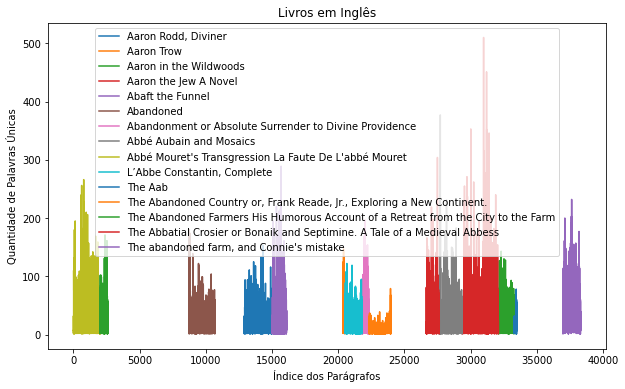

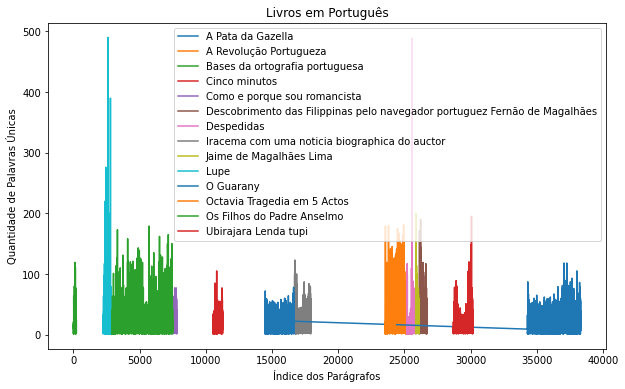

CPU times: user 1.04 s, sys: 39.7 ms, total: 1.08 s
Wall time: 8.13 s


In [18]:
%%time
english_df = spark.sql('''
    SELECT title, row_number, COUNT(DISTINCT exploded_table.word) AS unique_words
    FROM books
    LATERAL VIEW explode(keys) exploded_table AS word
    WHERE language = 'English'
    GROUP BY title, row_number
    ORDER BY title, row_number
''').toPandas()

# DataFrame contendo os dados dos livros em português
portuguese_df = spark.sql('''
    SELECT title, row_number, COUNT(DISTINCT exploded_table.word) AS unique_words
    FROM books
    LATERAL VIEW explode(keys) exploded_table AS word
    WHERE language = 'Portuguese'
    GROUP BY title, row_number
    ORDER BY title, row_number
''').toPandas()

# Gráfico para os livros em inglês
plt.figure(figsize=(10, 6))
for title, data in english_df.groupby('title'):
    plt.plot(data['row_number'], data['unique_words'], label=title)
plt.xlabel('Índice dos Parágrafos')
plt.ylabel('Quantidade de Palavras Únicas')
plt.title('Livros em Inglês')
plt.legend()
plt.show()

# Gráfico para os livros em português
plt.figure(figsize=(10, 6))
for title, data in portuguese_df.groupby('title'):
    plt.plot(data['row_number'], data['unique_words'], label=title)
plt.xlabel('Índice dos Parágrafos')
plt.ylabel('Quantidade de Palavras Únicas')
plt.title('Livros em Português')
plt.legend()
plt.show()

#### Montar dois histogramas um para os livros em inglês e o outro para os em português, para análise da frequência de palavras dos livros

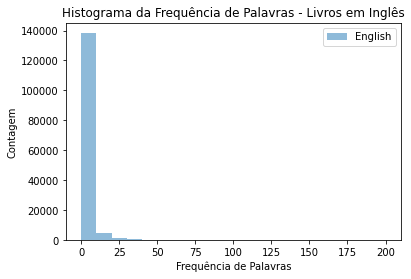

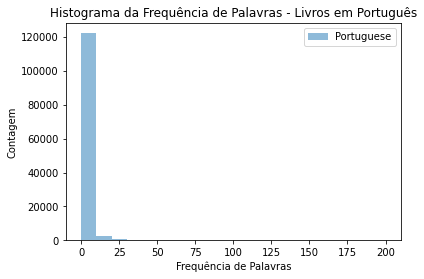

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 6.18 s


In [19]:
%%time
# Executar as consultas e obter os resultados
result_english = spark.sql("""
    SELECT COUNT(*) AS word_count
    FROM books
    LATERAL VIEW explode(keys) exploded_table AS word
    WHERE language = 'English'
    GROUP BY title, word
""").toPandas()

result_portuguese = spark.sql("""
SELECT COUNT(*) AS word_count
FROM books
LATERAL VIEW explode(keys) exploded_table AS word
WHERE language = 'Portuguese'
GROUP BY title, word
""").toPandas()

# Plotar o histograma para os livros em inglês
plt.hist(result_english['word_count'], bins=20, range=(0, 200), alpha=0.5, label='English')
plt.xlabel('Frequência de Palavras')
plt.ylabel('Contagem')
plt.title('Histograma da Frequência de Palavras - Livros em Inglês')
plt.legend()
plt.show()

# Plotar o histograma para os livros em português
plt.hist(result_portuguese['word_count'], bins=20, range=(0, 200), alpha=0.5, label='Portuguese')
plt.xlabel('Frequência de Palavras')
plt.ylabel('Contagem')
plt.title('Histograma da Frequência de Palavras - Livros em Português')
plt.legend()
plt.show()